# Рабочая тетрадь 

### Определение статуса сообщения (спам/обычное)

In [2]:
# Импорт библиотек
import warnings
warnings.filterwarnings('ignore') # будем игнорировать предупреждения
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords as sw
import re
import string
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
data = pd.read_csv('train_spam.csv')
pd.set_option('display.max_colwidth', 120)
test = pd.read_csv('test_spam.csv')

In [4]:
data.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in fifteen minutes as far as youre concerned
1,ham,a resume for john lavorato thanks vince i will get moving on it right away molly vince j kaminski 02 21 2001 05 55 p...
2,spam,plzz visit my website moviesgodml to get all movies for free and also i provide direct download links no redirect an...
3,spam,urgent your mobile number has been awarded with a £2000 prize guaranteed call 09061790121 from land line claim 3030 ...
4,ham,overview of hr associates analyst project per david s request attached is an overview of the hr associates analysts ...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


In [6]:
data.isna().sum() # выведем количество пропущенных

text_type    0
text         0
dtype: int64

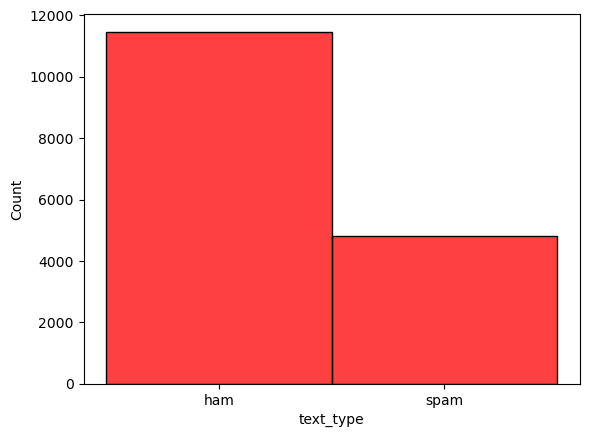

In [7]:
sns.histplot(data=data, x=data['text_type'], color='red');

In [8]:
data['count_punct'] = data['text'].apply(lambda x: np.sum([1 for i in x if i in string.punctuation]))

pattern = '[0-9!#$%&()*+,./:;<=>?@[\]^_`{|}~—/"/\-№]+'

def processing(text):
    '''
    Обработаем текст сообщений
    '''
    text = text.lower()
    ps = nltk.PorterStemmer()
    text = ps.stem(text)

    #wl = nltk.WordNetLemmatizer()
    #text = wl.lemmatize(text)
    text = re.sub(pattern, ' ', text)
    
    return text

data['text'] = data['text'].apply(lambda x: processing(x))
data['len_text'] = data['text'].apply(lambda x: len(x) - x.count(' '))

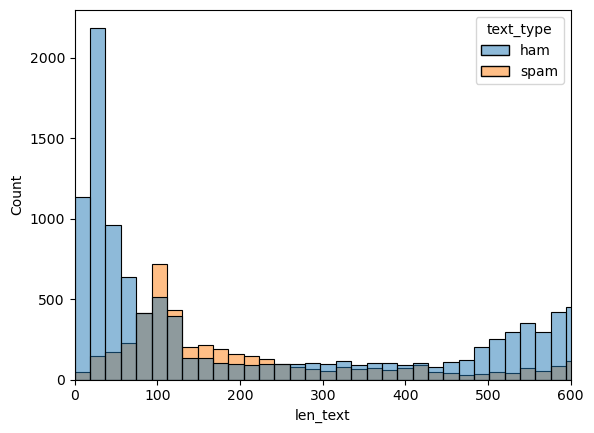

In [9]:
sns.histplot(data=data, x='len_text', hue='text_type', bins=40);
plt.xlim(0, 600);

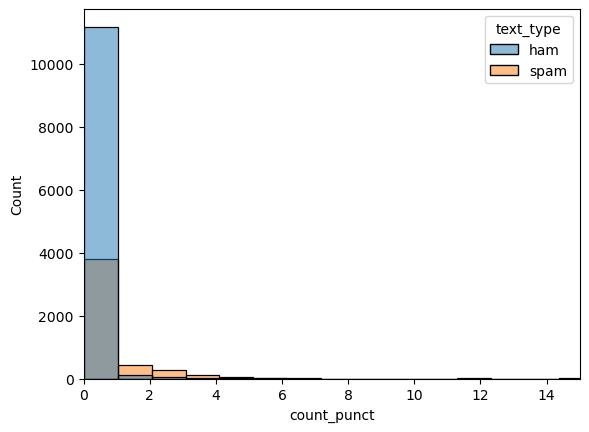

In [10]:
sns.histplot(data=data, x='count_punct', hue='text_type', bins=37);
plt.xlim(0, 15);

In [11]:
# Видим, что есть различия в длине сообщения; в количестве знаков препинания различия не ощущаются
# удалим столбец count_punct, стандартизируем значения len_text
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data['len_text'] = scaler.fit_transform(pd.DataFrame(data['len_text']))
data = data.drop(['count_punct'], axis = 1)
data.head()

,text_type,text,len_text
0,ham,make sure alex knows his birthday is over in fifteen minutes as far as youre concern,-0.760817
1,ham,a resume for john lavorato thanks vince i will get moving on it right away molly vince j kaminski pm to mo...,0.760398
2,spam,plzz visit my website moviesgodml to get all movies for free and also i provide direct download links no redirect an...,-0.600689
3,spam,urgent your mobile number has been awarded with a £ prize guaranteed call from land line claim valid hrs only ...,-0.654065
4,ham,overview of hr associates analyst project per david s request attached is an overview of the hr associates analysts ...,1.578829


In [12]:
stop_words = sw.words('english')
tv_model = TfidfVectorizer(stop_words=stop_words, binary=True)

In [13]:
X_tv = tv_model.fit_transform(data['text'])
X_tv

<16278x48642 sparse matrix of type '<class 'numpy.float64'>'
	with 423028 stored elements in Compressed Sparse Row format>

Получилась слишком большая матрица (слишком много разных слов). 

Давайте уберем слова, которые встречаются менее чем в 0.5% text

In [69]:
names = tv_model.get_feature_names_out()
print(mask.A1)

[False False False ... False False False]


In [74]:
# Вычисляем частоту каждого слова во всех документах
term_freqs = np.sum(X_tv.toarray(), axis=0)

# Вычисляем количество документов, в которых встречается каждое слово
doc_freqs = np.sum(X_tv != 0, axis=0)

# Оставляем только те слова, которые встречаются в более чем 1% документов
min_doc_freq = int(len(data) * 0.005)
mask = (doc_freqs >= min_doc_freq).A1

# Переиндексируем массив names
names = np.array(tv_model.get_feature_names_out())[mask]
names = names[np.argsort(term_freqs[mask])]

# Создаем новый объект TfidfVectorizer с указанным словарём
vocab = {word: idx for idx, word in enumerate(names)}
new_vectorizer = TfidfVectorizer(vocabulary=vocab)

# Преобразуем тексты в матрицу tf-idf
new_X_matrix = new_vectorizer.fit_transform(data['text'])

In [75]:
X_features = pd.concat([data['len_text'], pd.DataFrame(new_X_matrix.toarray())], axis=1)
X_features.columns = X_features.columns.astype(str)

In [77]:
# Будем использовать алгоритм случайного леса 
# Т.к. данный алгоритм определяет высокую точность и устойчив к переобучению
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_features, data['text_type'])

RandomForestClassifier()

In [78]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=5)
cross_val_score(rf_model, 
                X_features, 
                data['text_type'], 
                cv=k_fold, 
                scoring='accuracy')

array([0.92997543, 0.94041769, 0.93888206, 0.93732719, 0.9265745 ])

Видим, что точность примерно 93-94%, давайте посмотрим другие метрики

In [128]:
#from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score as score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, 
                                                     data['text_type'], 
                                                     test_size=0.2, 
                                                     random_state=1)

In [129]:
rf = RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1)
rf_model = rf.fit(X_train, y_train)

In [130]:
# Выведем наиболее важные фичи
sorted(zip(rf_model.feature_importances_, X_train.columns), reverse=True)[0:10]

[(0.08863600523163484, 'len_text'),
 (0.047602784262147244, '888'),
 (0.042781658335534364, '824'),
 (0.03467467383381566, '826'),
 (0.03350654204459746, '870'),
 (0.03018157532564233, '899'),
 (0.020989327425670768, '843'),
 (0.019599157807012848, '895'),
 (0.019043587412440482, '778'),
 (0.017881930386963348, '892')]

In [137]:
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='spam')
roc_auc = score(y_test, y_pred_proba)

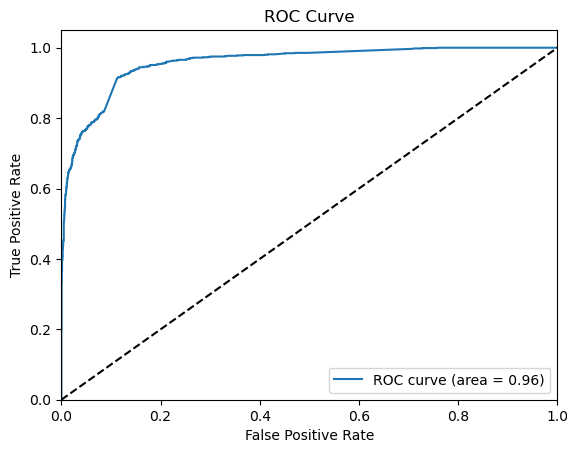

In [138]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### найдем оптимальный набор гиперпараметров модели с помощью поиска по сетке

In [139]:
from sklearn.model_selection import GridSearchCV

In [140]:
rf = RandomForestClassifier()
params = {'n_estimators': [10, 25, 100, 200],
          'max_depth': [10, 30, 60, None]}
grid = GridSearchCV(estimator=rf_model, param_grid=params, cv=5)

In [141]:
grid = grid.fit(X_train, y_train)
pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,2.423379,0.033138,0.069474,0.001511,None,200,"{'max_depth': None, 'n_estimators': 200}",0.935893,0.928215,0.931260,0.929724,0.934332,0.931884,0.002849,1
14,1.247486,0.014392,0.050774,0.004858,None,100,"{'max_depth': None, 'n_estimators': 100}",0.930902,0.928599,0.929339,0.929339,0.935484,0.930733,0.002491,2
11,1.585134,0.030629,0.059979,0.001881,60,200,"{'max_depth': 60, 'n_estimators': 200}",0.930902,0.930134,0.923579,0.932412,0.931644,0.929734,0.003169,3
10,0.830454,0.026061,0.035543,0.000816,60,100,"{'max_depth': 60, 'n_estimators': 100}",0.929750,0.927831,0.928571,0.931260,0.927035,0.928890,0.001484,4
13,0.412922,0.009342,0.026131,0.000601,None,25,"{'max_depth': None, 'n_estimators': 25}",0.931670,0.920921,0.921659,0.923963,0.929339,0.925511,0.004264,5


In [146]:
model = grid.best_estimator_

RandomForestClassifier(n_estimators=200, n_jobs=-1)


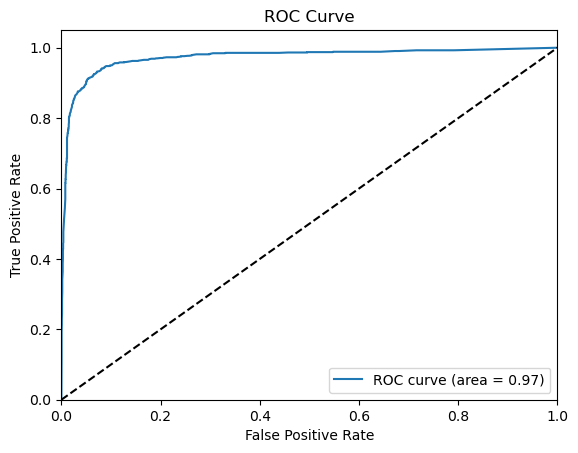

In [147]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='spam')
roc_auc = score(y_test, y_pred_proba)
print(model)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [148]:
from sklearn.ensemble import GradientBoostingClassifier

In [152]:
gb_model = GradientBoostingClassifier()
gb_model = gb_model.fit(X_train, y_train)
params = {'n_estimators': [25, 50, 150],
          'max_depth': [5, 11, 17],
          'learning_rate': [0.01, 0.1, 1]}
grid = GridSearchCV(estimator=gb_model, param_grid=params, cv=5, n_jobs=-1)
grid = grid.fit(X_train, y_train)
pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)[0:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,107.609091,0.419273,0.122861,0.011901,0.1,11,150,"{'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 150}",0.930134,0.922073,0.921659,0.934332,0.928571,0.927354,0.004863,1
17,171.660901,3.604527,0.139157,0.019741,0.1,17,150,"{'learning_rate': 0.1, 'max_depth': 17, 'n_estimators': 150}",0.929367,0.921689,0.921275,0.933564,0.925883,0.926356,0.004666,2
16,58.542142,0.298141,0.063446,0.003976,0.1,17,50,"{'learning_rate': 0.1, 'max_depth': 17, 'n_estimators': 50}",0.923225,0.915931,0.911674,0.925115,0.917819,0.918753,0.004887,3
20,48.365875,0.279805,0.051379,0.001067,1,5,150,"{'learning_rate': 1, 'max_depth': 5, 'n_estimators': 150}",0.919002,0.914012,0.908602,0.923195,0.920507,0.917064,0.005179,4
26,99.140466,5.111462,0.058194,0.004930,1,17,150,"{'learning_rate': 1, 'max_depth': 17, 'n_estimators': 150}",0.920154,0.915163,0.915515,0.916667,0.915899,0.916679,0.001808,5
11,47.972052,0.182806,0.077057,0.015298,0.1,5,150,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}",0.911324,0.914779,0.908986,0.924347,0.922811,0.916450,0.006125,6
23,107.774848,1.524242,0.079774,0.018018,1,11,150,"{'learning_rate': 1, 'max_depth': 11, 'n_estimators': 150}",0.917083,0.916315,0.913978,0.922427,0.912058,0.916372,0.003507,7
13,38.236252,0.374567,0.056582,0.004093,0.1,11,50,"{'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 50}",0.914012,0.915931,0.905914,0.917819,0.915515,0.913838,0.004144,8
22,36.313398,0.346262,0.053471,0.012649,1,11,50,"{'learning_rate': 1, 'max_depth': 11, 'n_estimators': 50}",0.908637,0.917083,0.904762,0.919355,0.916283,0.913224,0.005558,9
25,54.135544,2.290944,0.052635,0.019760,1,17,50,"{'learning_rate': 1, 'max_depth': 17, 'n_estimators': 50}",0.916315,0.911324,0.907066,0.920891,0.910138,0.913147,0.004886,10


In [153]:
model = grid.best_estimator_

GradientBoostingClassifier(max_depth=11, n_estimators=150)


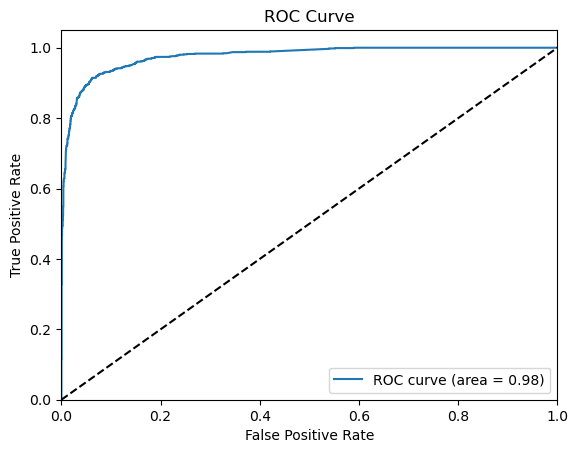

In [154]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='spam')
roc_auc = score(y_test, y_pred_proba)
print(model)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Видим, что ROC лучше у градиентного бустинга (0.98 против 0.97)

In [180]:
test = pd.read_csv('test_spam.csv')

In [181]:
model

GradientBoostingClassifier(max_depth=11, n_estimators=150)

In [194]:
# Вычисляем частоту каждого слова во всех документах
term_freqs = np.sum(X_tv.toarray(), axis=0)

# Вычисляем количество документов, в которых встречается каждое слово
doc_freqs = np.sum(X_tv != 0, axis=0)

# Оставляем только те слова, которые встречаются в более чем 1% документов
min_doc_freq = int(len(data) * 0.005)
mask = (doc_freqs >= min_doc_freq).A1

# Переиндексируем массив names
names = np.array(tv_model.get_feature_names_out())[mask]
names = names[np.argsort(term_freqs[mask])]

# Создаем новый объект TfidfVectorizer с указанным словарём
vocab = {word: idx for idx, word in enumerate(names)}
new_vectorizer = TfidfVectorizer(vocabulary=vocab)

# Преобразуем тексты в матрицу tf-idf
new_vectorizer.fit(data['text'])
scaler = StandardScaler()

len_text = test['text'].apply(lambda row: len(row))

test_matrix = new_vectorizer.transform(test['text'])
test_matrix = pd.concat([len_text, pd.DataFrame(test_matrix.toarray())], axis=1)

test_matrix.columns = test_matrix.columns.astype(str)

test_matrix = test_matrix.rename(columns={'text': 'len_text'})
test_matrix['len_text'] = scaler.fit_transform(pd.DataFrame(test_matrix['len_text']))

In [204]:
score = model.predict(test_matrix)

In [205]:
result_df = pd.DataFrame({'text': test['text'], 'score': score})

In [207]:
result_df.head()

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you open sourced the new components you developed for this j project so th...,ham
1,original message from bitbitch magnesium net people are screaming and shouting over the political figures because th...,ham
2,java for managers vince durasoft who just taught the java class for our group offers a 3 day short course in java fo...,ham
3,there is a youtuber name saiman says,ham
4,underpriced issue with high return on equity the oil and gas advisory now that oil and gas has entered a long term b...,spam


In [208]:
result_df.to_csv('result.csv', index=False)